Project 4: Generative Adversarial Networks
======
In this project, you are expected to fill in the missing parts of a PyTorch implementation of the Deep Convolutional Generative Adversarial Network (DCGAN) [1] and test its performance on several datasets.<br>
Please **read the instructions carefully**. We provide reference outputs for most tasks and we will judge your solution based on your code as well as on the quality of your output and similarity to our results.

We will be using datasets with small images for this project, because high-resolution GANs take notoriously long to train.

**References:**

[1] [Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.](https://arxiv.org/abs/1511.06434)

[2] [MNIST dataset.](http://yann.lecun.com/exdb/mnist/)

[3] [FashionMNIST dataset.](https://github.com/zalandoresearch/fashion-mnist)

[4] [UTKFace dataset.](https://susanqq.github.io/UTKFace/)

!unzip img.zip

## Assignment 4A: DCGAN

### Verify your PyTorch installation

In [3]:
import torch
import torchvision

# Print Basic Information
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print("Torchvision", torchvision.__version__)
print('Device:', torch.device('cuda:0'))
device = torch.device("cuda:0")

Torch 1.3.0 CUDA 10.1.243
Torchvision 0.4.1
Device: cuda:0


In [4]:
#import statements
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torchsummary import summary
import numpy as np

In [5]:
#######################################################################################################
# TODO 1: Load dataset. Implement the necessary functions so your data has a resolution of 32x32 pixels
# and the values are normalized to a [-1, 1] range. 
# Consider whether you can implement some data augmentation, and if possible, do so.
#######################################################################################################
# transformation 
# the training task is generating real images, augumention operation may make
# the pics look unreal or fake.
transform = transforms.Compose([
                    transforms.Resize(32),
                    transforms.ToTensor(),
    # the pictures in minist dataset is grayscaled, which means there is only one sigle channel
                    transforms.Normalize([0.5], [0.5])])
train_dataset = datasets.MNIST('./minist', download=True, transform=transform)

In [6]:
print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  60000
Image size: torch.Size([1, 32, 32])
value range: [ -1.0 - 0.9843137264251709 ]


#### Inspect the training data

**Visualize a few examples** from your training data.

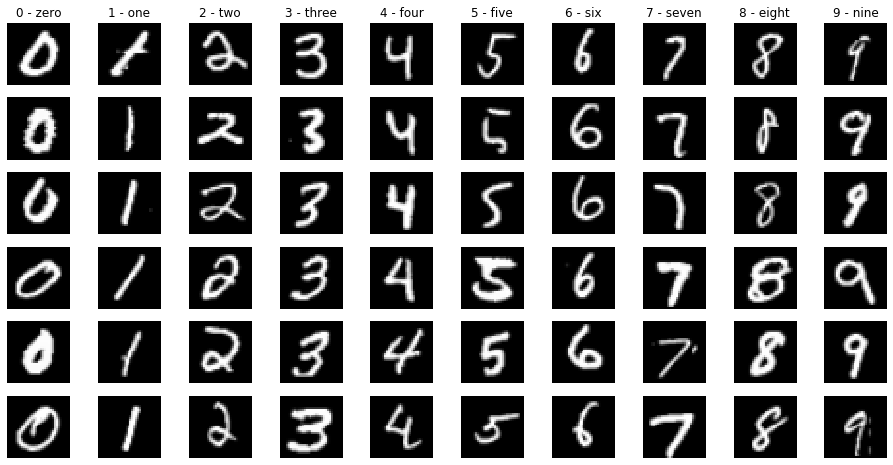

In [7]:
labels = train_dataset.classes
fig = plt.figure(figsize=(16, 8))
rows = 6

images = {}
for label in range(len(labels)):
    images[label] = []

#find some images for each label    
for x in range(1000):
    rand = np.random.randint(len(train_dataset))
    label = train_dataset[rand][1]
    if len(images[label]) > rows:
        continue
    images[label].append(train_dataset[rand][0][0,:,:])
    
for label in range(len(labels)):
    for row in range(rows):
        image = images[label][row]
        fig.add_subplot(rows, len(labels), row * len(labels) + label + 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        if row == 0:
            plt.title(labels[label])
plt.show()

Create a function to initialize the weights for `nn.Conv2d` and `nn.ConvTranspose2d` layers with a custom distribution. To that end, complete the function `normal_init`, which initialized the weights of the given pytorch layer with a Normal distribution centered around $mean$ and a standard deviation $std$.

##### Hint: 
`summary` from the `torchsummary` package is a very helpful tool to inspect the layers in your network. Use it like so:

```
M = MyNetwork()
M.cuda()
summary(M, input_size=myExpectedInputSize)
```

In [8]:
#######################################################################################################
# TODO 3a: implement a function that initializes the layer's weights with mean and standard deviation.
#######################################################################################################
def normal_init(layer, mean, std):
    nn.init.normal_(layer.weight.data, mean, std)

## Assignment 4B: Conditional DCGAN

Our previous Generator network was generating random outputs for each input latent vector without any measure of control over the output. 
Now, we would like to add some control mechanism such that we can determine the class for a generated image, e.g. generate only the number $5$ or images from the category $Shirt$.

The expected output of this GAN should look like this (or better):

<img src="img/cond_DCGAN_MNIST.png" align='left' width="550">
<img src="img/cond_DCGAN_fashionMNIST.png" align='left' width="550">

For simplicity, we will use either _MNIST_ or _FashionMNIST_ at $32\times32$ grayscale for this exercise again.

For a class-conditioned output, we need to modify both the generator as well as the discriminator network to accept a class label as part of the input. These labels need to be transformed from a "categorical" input to a numerical vector. Use `torch.nn.Embedding` to transform the label to such an embedding space.

### 8) Modify Networks for conditional GANs (4 points)

Select appropriate training hyperparameters.

In [9]:
# TODO: choose reasonable values
# batch_size = 128
# lr = 0.0002
# train_epoch = 20
batch_size = 128
num_epochs = 10
learning_rate = 0.0002

### 9) Design a conditional discriminator network (8 points)

In [10]:
#######################################################################################################
#TODO 9: update the discriminator network to incorporate the label input
#######################################################################################################
class Discriminator(nn.Module):
    def __init__(self, mean, std, n_classes=10):
        super(Discriminator, self).__init__()
        
        self.embedding = nn.Embedding(n_classes, 50)
        
        self.fc = nn.Linear(50, 64)
        
        self.d_network_one = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(128, 128 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128 * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.d_network_two = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(128 * 2 + 1, 128 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(128 * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        self.weight_init(mean, std)
    
    def forward(self, x, labels):
        x = self.d_network_one(x)
        label_embedding = self.embedding(labels)
        condition = self.fc(label_embedding)
        condition = condition.view(-1,1,8,8)
        # concatenate
        x = torch.cat((x, condition), 1)
        x = self.d_network_two(x)
        return x
    
    def weight_init(self, mean, std):
        conv_name = 'Conv2d'
        for layer in self.d_network_one:
            if type(layer).__name__ == conv_name:
                normal_init(layer,mean,std)
        for layer in self.d_network_two:
            if type(layer).__name__ == conv_name:
                normal_init(layer,mean,std)

### 8) Design a conditional generator network (8 points)

In [11]:
#######################################################################################################
#TODO 10: update the generator network to incorporate the label input
#######################################################################################################
class Generator(nn.Module):
    def __init__(self, mean, std, n_classes=10):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(n_classes, 50)
        self.fc = nn.Linear(50, 64)
        self.g_network_one = nn.Sequential(
            # input is Z, which has 100 channels
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True))
            # state size. (ngf*4) x 8 x 8)
        self.g_network_two = nn.Sequential(
            # the original number of channels should be plus one
            nn.ConvTranspose2d( 64 * 4 + 1, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 1, 4, 2, 1, bias=False),
            nn.Tanh())
            # state size. 1 x 32 x 32)
        self.weight_init(mean, std)
        
    def forward(self, x, labels):
        x = self.g_network_one(x)
        label_embedding = self.embedding(labels)
        condition = self.fc(label_embedding)
        condition = condition.view(-1,1,8,8)
        # concatenate
        x = torch.cat((x, condition), 1)
        x = self.g_network_two(x)
        return x
    
        # weight_init
    def weight_init(self, mean, std):
        # initialize all the ConvTranspose2d layers' weights
        conv_t_name = 'ConvTranspose2d'
        for layer in self.g_network_one:
            if type(layer).__name__ == conv_t_name:
                normal_init(layer,mean,std)
        for layer in self.g_network_two:
            if type(layer).__name__ == conv_t_name:
                normal_init(layer,mean,std)

#### Complete the output function (5 points)

In [12]:
# output generated samples from the current state of the generator network
n_samples = 5

#######################################################################################################
# TODO 11: generate a fixed noise vector and a fixed set of labels to evaluate the output of the generator
# with the same noise parameters as training progresses.
# Arrange the labels into a grid to show same label outputs in the same column (see example results above) 
#######################################################################################################
fixed_z = torch.randn(n_samples*2,100,1,1).to(device)
# fixed_labels = torch.LongTensor(n_samples).random_(0, 10).to(device)
fixed_labels = torch.LongTensor(np.arange(10)).to(device)
print(fixed_labels)

def show_conditional_result(num_epoch, show=False, save=False, n_classes=10, n_samples=5, path='result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z, fixed_labels).cpu()
        else:
            # TODO generate a new random noise vector and a grid of labels
            z = torch.randn(n_samples*2,100,1,1).to(device)
            labels = torch.LongTensor(n_samples*2).random_(0, 10).to(device)

            fake = G(z, labels).cpu()

        fig, ax = plt.subplots(figsize=(20, 10))
        image = utils.make_grid(fake.data, n_classes, 1,normalize=True)

        plt.imshow(np.transpose(image, (1, 2, 0)))

        ax.axis('off')

        plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()   

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


<font color="red">From my point of view, the embedding for each class should be consistent in G and D</font>

#### Complete the training setup (5 points) and training loop (10 points)

Training ...
Epoch [1 / 10] G loss: 14.062950134277344 D loss: 1.424765706062317


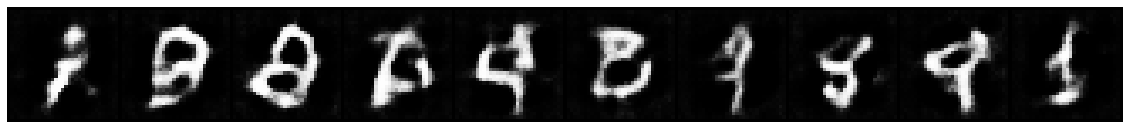

Epoch [2 / 10] G loss: 3.2326037883758545 D loss: 0.18658311665058136


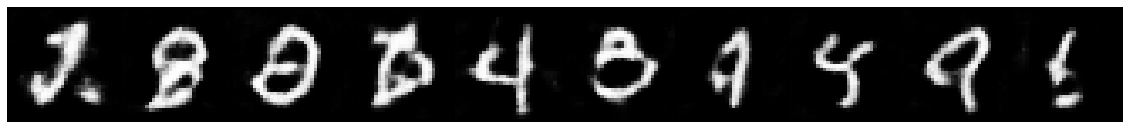

Epoch [3 / 10] G loss: 1.5267976522445679 D loss: 0.8050614595413208


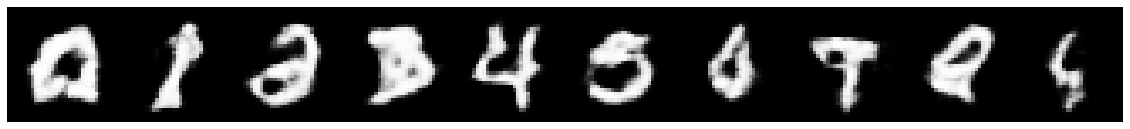

Epoch [4 / 10] G loss: 2.5069310665130615 D loss: 0.2614264488220215


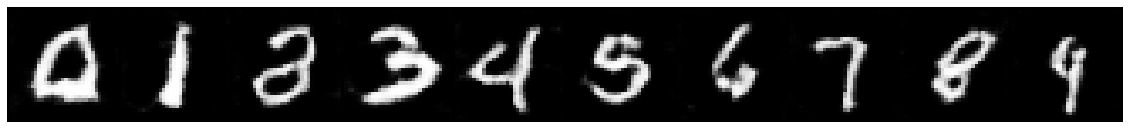

Epoch [5 / 10] G loss: 3.434467077255249 D loss: 0.11737041175365448


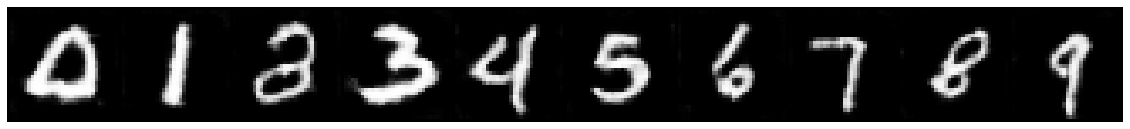

Epoch [6 / 10] G loss: 3.7705094814300537 D loss: 0.2358628511428833


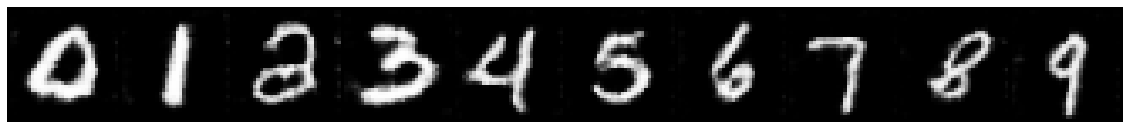

Epoch [7 / 10] G loss: 4.323272228240967 D loss: 0.04167996346950531


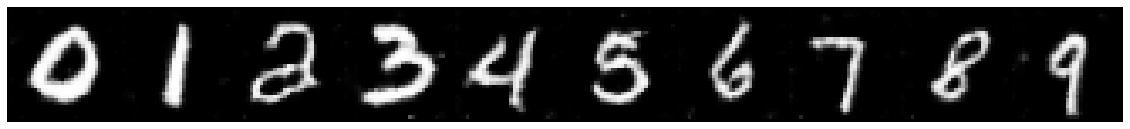

Epoch [8 / 10] G loss: 4.480404853820801 D loss: 0.038830433040857315


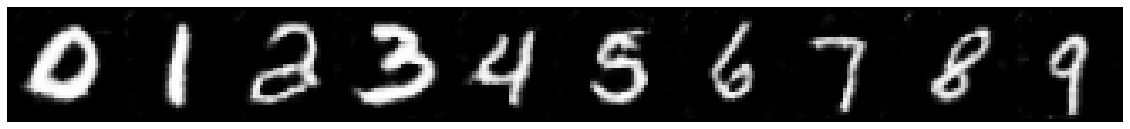

Epoch [9 / 10] G loss: 0.7561348080635071 D loss: 0.9385713338851929


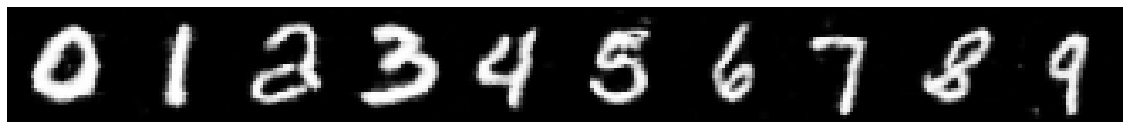

Epoch [10 / 10] G loss: 4.82182502746582 D loss: 0.3588904142379761


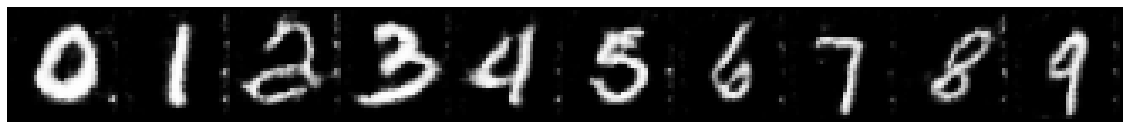

Avg per epoch time: 387.40 sec, total 10 epochs time: 64.69 min
Training finished!
...saving training results


In [13]:
plt.ion()

# define dataloader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dset_name = '1107'
result_dir = '{}_conditional_DCGAN'.format(dset_name)

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
    
# Initialize BCELoss function
criterion = nn.BCELoss()  
device = torch.device("cuda:0")

#######################################################################################################
# TODO 12: define training setup
#######################################################################################################

mean = 0
dev = 0.02
# TODO define networks
G = Generator(mean, dev).to(device)
D = Discriminator(mean, dev).to(device)

# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    num_batches = 0
    # real is the image and label is the order of the image represented by a integer number
    for real, real_labels in data_loader:
        
        #######################################################################################################
        # TODO 13: Fill code for training loop
        #######################################################################################################
        real = real.to(device)
        real_labels = real_labels.to(device)
        # generate random latent vector z and random class assignments for each generated image in the minibatch as well as real and fake labels 
        batch_size = real.size(0)
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        # 10 is the number of classes
        random_labels = torch.LongTensor(batch_size).random_(0, 10).to(device)
        real_label = torch.full((batch_size,), 1).to(device)
        fake_label = torch.full((batch_size,), 0).to(device)
        # TODO 
        # generate fakes    
        fakes = G(z, random_labels).to(device)
        # TODO 
        err_fakes_D = criterion(D(fakes.detach(),random_labels).view(-1), fake_label)
        # evaluate fakes
        # TODO 
        err_real_D = criterion(D(real, real_labels).view(-1), real_label)
        # evaluate real minibatch
        # TODO
        D_train_loss = err_fakes_D + err_real_D
        # accumulate discriminator loss from the information about the real and fake images it just saw

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step() 
        
        # train generator to output an image that is classified as real              
        G_train_loss = criterion(D(fakes, random_labels).view(-1), real_label)     
        
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())
        
        epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_conditional_result( epoch, save=True, show=True, path=result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)
     
end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

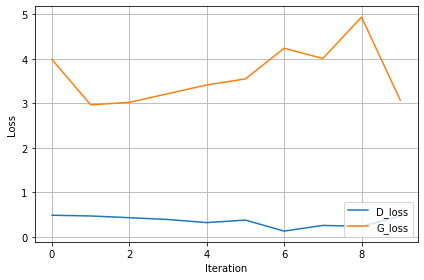

In [17]:
torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot loss curves
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# show training progress as animation
images = []
for e in range(num_epochs):
    img_name = result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/conditional_DCGAN_generation_animation.gif', images, fps=5)

### Display the animated generation GIF

% **TODO: edit path to GIF** %

<img src='full_path_to_gif.gif' width="512">

In [16]:
# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()